In [484]:
import polars as pl
import numpy as np
import os
import json
os.chdir(os.path.expanduser('~/vEcoli'))
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix

# LB Media Data

## Ground truth data from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/)

Media type: LB media

Bacterial species: I believe E. coli BW25113

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: need to confirm if this is the correct strain of E. coli


In [485]:
# load in the "ground truth" data that cyrus collected from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/): 
GT_data = pd.read_csv("notebooks/mia_notebooks/cofactor_ground_truth_data_from_cyrus_for_mia.csv")
GT_data

,Condition,Below_LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log_concentration,Concentration_(M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1000.000000,-5.485784,3.267501e-06,3983.324414
1,Minimal,0,1,ZN,205.106947,354.00,9.08603,55212.922173,-3.785417,1.639017e-04,199808.236064
2,Minimal,0,1,CU,149.815832,354.00,9.08603,1000.000000,-5.191123,6.439870e-06,7850.676467
3,Minimal,1,1,NI,137.331179,354.00,9.08603,1000.000000,-5.508529,3.100778e-06,3780.077086
4,Minimal,1,1,CO,103.448109,354.00,9.08603,1000.000000,-6.369963,4.266155e-07,520.075813
5,Minimal,0,1,FE,203.321486,354.00,9.08603,24669.603524,-3.830810,1.476353e-04,179978.374255
6,Minimal,0,1,MN,135.088853,354.00,9.08603,1000.000000,-5.565538,2.719333e-06,3315.067378
7,Minimal,0,1,CR,122.171244,354.00,9.08603,1000.000000,-5.893951,1.276582e-06,1556.247155
8,Minimal,0,1,V,113.253635,354.00,9.08603,1000.000000,-6.120670,7.574077e-07,923.335846
9,Rich,0,1,MO,146.248788,353.14,9.30606,1000.000000,-5.272756,5.336351e-06,10797.032626


In [486]:
# LB media data from GT data: 
GT_lb_data = GT_data[9:]
GT_lb_df = pl.DataFrame(GT_lb_data[["Element","Atoms/cell"]])
GT_lb_df = GT_lb_df.with_columns(pl.col("Atoms/cell").log10().alias("E. coli BW25113 (Outten & O'Halloran, 2001 (GT Data))"))

# replace the element names with the column names for merging later:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_lb_df = GT_lb_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_lb_df = pl.DataFrame(GT_lb_df[["Element", "E. coli BW25113 (Outten & O'Halloran, 2001 (GT Data))"]])
GT_lb_df

Element,"E. coli BW25113 (Outten & O'Halloran, 2001 (GT Data))"
str,f64
"""Mo""",4.033304
"""Zn""",5.601669
"""Cu""",4.942388
"""Ni""",3.510581
"""Co""",2.646951
"""Fe""",5.783291
"""Mn""",4.669722
"""Cr""",3.533308
"""V""",2.396953


## LB media data from Huynh et al., 2022 fig 1c and 1d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 

Media type: LB media

Bacterial species: E. coli K-12 BW25113

Units used in calculations: Atoms/CFU

QUESTIONS/ISSUES: 
- double check that I did my web plot analyzer stuff right when I do it for the minimal media conditions

In [487]:
# load in LB media data from Huynh et al., 2022 fig 1c and d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
Huynh_2022 = pd.read_excel("notebooks/mia_notebooks/Huynh_2022_F1CD_data.xlsx")

# convert data frames to polars data frames and rename the columns to be more descriptive: 
Huynh_2022 = pl.DataFrame(Huynh_2022[["Element","log10 LB (atoms/CFU)"]])
LBM_F1_2022_df = Huynh_2022.with_columns(pl.col("log10 LB (atoms/CFU)").alias("LBM_Huynh_log_APC"))
LBM_F1_2022_df

Element,log10 LB (atoms/CFU),LBM_Huynh_log_APC
str,f64,f64
"""Mn""",3.5727,3.5727
"""Fe""",5.79822,5.79822
"""Cu""",4.596439,4.596439
"""Zn""",4.534125,4.534125
"""V""",2.699801,2.699801
"""Cr""",4.230616,4.230616
"""Co""",1.976143,1.976143
"""Ni""",3.38171,3.38171


## LB media data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data):

Media type: LB media

Bacterial species: I think E. coli strain BW25113 (derived from K-12 lineage)

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 
- not entirely sure about what strain is used in the specific graph here, but pretty sure it is BW25113 (the WT in the paper) 

In [488]:
# data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data): 
LBM_F1_2019 = pd.read_excel("notebooks/mia_notebooks/Budhraja_2019_F1_data.xlsx")
LBM_F1_2019

,metal,metal ions per cell (ranging from 1000 to 1E+09),Upper error,lower error,metal ions per cell (using 3 to 9 as the axis only),raise to ten,Upper Error,Lower Error,10^ (col E)
0,Mo,1.455079e+04,1.497124e+04,1.414215e+04,4.166667,1.467799e+04,4.179012,4.154321,1.467799e+04
1,Ni,1.394215e+04,1.475952e+04,1.317006e+04,4.148148,1.406527e+04,4.172840,4.123457,1.406527e+04
2,Co,3.261385e+03,3.502111e+03,2.994254e+03,3.518519,3.300035e+03,3.549383,3.481481,3.300035e+03
3,Fe,2.038348e+06,2.157847e+06,1.953087e+06,6.308642,2.035363e+06,6.333333,6.290123,2.035363e+06


In [489]:
# LB media from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data):
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","raise to ten"]])
# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("raise to ten").log10().alias("LBM_Budhraja_log_APC"))
LBM_F1_2019_df

metal,raise to ten,LBM_Budhraja_log_APC
str,f64,f64
"""Mo""",14677.992676,4.166667
"""Ni""",14065.272421,4.148148
"""Co""",3300.034791,3.518519
"""Fe""",2.0354e6,6.308642


## LB media data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11)

Media type: LB media

Bacterial species: E. coli MG1655

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [490]:
# data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T112_2017 = pd.read_excel("notebooks/mia_notebooks/Umemura_2017_T112_data.xlsx")

# transform into a polars data frame and rename the columns:
LBM_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in LB"]])
LBM_T112_2017_df = LBM_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in LB").log10().alias("LBM_Umemura_T112_log_APC"))
LBM_T112_2017_df

Symbol,E. coli MG1655 in LB,LBM_Umemura_T112_log_APC
str,f64,f64
"""Mg""",7.5e7,7.875061
"""P""",4.2e8,8.623249
"""S""",1.7e8,8.230449
"""K""",2.6e8,8.414973
"""Ca""",6.2e6,6.792392
…,…,…
"""Au""",0.25,-0.60206
"""Tl""",45.0,1.653213
"""Pb""",60.0,1.778151


## LB media data from Nies & Herzberg, 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123 / Kristen et al., 2011: https://journals.asm.org/doi/full/10.1128/jb.05293-11

Media type: LB media

Bacterial species: E. coli W3110 

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [491]:
# LB media data from Nies et al., 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123
Nies_2012 = pd.read_excel("notebooks/mia_notebooks/Nies_2012_T1_data.xlsx")
Nies_2012 = pl.DataFrame(Nies_2012[["Element", "Atoms/cell"]])
N_2012 = Nies_2012.with_columns(pl.col("Atoms/cell").log10().alias("E. coli W3110 (Nies & Herzberg, 2012)"))
N_2012

Element,Atoms/cell,"E. coli W3110 (Nies & Herzberg, 2012)"
str,f64,f64
"""Mg""",1.27e7,7.103804
"""Ca""",2.0500e6,6.311754
"""Fe""",290000.0,5.462398
"""Co""",4500.0,3.653213
"""Ni""",9700.0,3.986772
"""Zn""",114000.0,5.056905
"""Mn""",11700.0,4.068186
"""Mo""",3450.0,3.537819
"""Cu""",169000.0,5.227887


## Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23#F4):

Media type: LB media

Bacterial species: uropathogenic E. coli strain CFT073 (UPEC)

Units used in calculations: pg/10^6 CFU

QUESTIONS/ISSUES: 
- Did I do my conversion right? 

In [492]:
# LB media from Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23):
SH_F2A_2024 = pd.read_excel("notebooks/mia_notebooks/Saenkham_2024_F2a_data.xlsx")
SH_F2A_2024 = pl.DataFrame(SH_F2A_2024)
SH_F2A_2024

Element,CFT073/pGEN (pg/10^6 CFU),yhiM/pGEN (pg/10^6 CFU),yhim_yhim (pg/10^6 CFU)
str,f64,f64,f64
"""Cu""",114.675768,77.8157,135.153584
"""Fe""",821.25,615.0,1023.75
"""Mn""",22.0,19.4,47.4
"""Zn""",780.0,772.5,1087.5


In [493]:
# convert units to atoms/CFU:
# pg to g: 1 pg = 10^-12 g
SH_LBM_2024 = pl.DataFrame(SH_F2A_2024[["Element", "CFT073/pGEN (pg/10^6 CFU)"]])
SH_LBM_2024 = SH_LBM_2024.with_columns((pl.col("CFT073/pGEN (pg/10^6 CFU)") * 10**(-12)).alias("CFT073/pGEN (g/10^6 CFU)"))

# g/10^6 CFU to g/CFU:
SH_LBM_2024 = SH_LBM_2024.with_columns((pl.col("CFT073/pGEN (g/10^6 CFU)") / 10**6).alias("CFT073/pGEN (g/CFU)"))

# conversion numbers (all masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# g to atoms:
Cu_value = SH_LBM_2024.filter(pl.col("Element") == "Cu").select("CFT073/pGEN (g/CFU)").item()
Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = SH_LBM_2024.filter(pl.col("Element") == "Fe").select("CFT073/pGEN (g/CFU)").item()
Fe_value = (Fe_value / mm_Fe) * Avogadro
Mn_value = SH_LBM_2024.filter(pl.col("Element") == "Mn").select("CFT073/pGEN (g/CFU)").item()
Mn_value = (Mn_value / mm_Mn) * Avogadro
Zn_value = SH_LBM_2024.filter(pl.col("Element") == "Zn").select("CFT073/pGEN (g/CFU)").item()
Zn_value = (Zn_value / mm_Zn) * Avogadro

# create new data frame: 
values = [Cu_value, Fe_value, Mn_value, Zn_value]
SH_LBM_2024 = SH_LBM_2024.with_columns([pl.Series("CFT073/pGEN (atoms/CFU)", values)])
SH_2024 = pl.DataFrame(SH_LBM_2024[["Element", "CFT073/pGEN (atoms/CFU)"]])
SH_2024 = SH_2024.with_columns(pl.col("CFT073/pGEN (atoms/CFU)").log10().alias("uropathogenic E. coli CFT073 (Saenkham-Huntsinger, et al., 2024)"))
SH_2024

Element,CFT073/pGEN (atoms/CFU),"uropathogenic E. coli CFT073 (Saenkham-Huntsinger, et al., 2024)"
str,f64,f64
"""Cu""",1.0867e6,6.036124
"""Fe""",8.8559e6,6.947232
"""Mn""",241151.843897,5.382291
"""Zn""",7.1844e6,6.85639


## Casanova-Hampton et al., 2021: https://academic.oup.com/metallomics/article/13/9/mfab052/6355450

Media type: LB media

Bacterial species: E. coli BW25113 (derived from K-12 lineage)

Units used in calculations: ng/mg

QUESTIONS/ISSUES:
- need to confirm if it was right to multiply by wet weight based on the paper?

In [494]:
# load in the data from Casanova-Hampton et al., 2021: https://academic.oup.com/metallomics/article/13/9/mfab052/6355450
CH_F7_2021 = pd.read_excel("notebooks/mia_notebooks/CasanovaHampton_2021_F4_data.xlsx")
CH_F7_2021

,Element,ng/mg
0,Cu,1.079824
1,Fe,33.169774
2,Zn,8.307692
3,Mn,0.805627


In [495]:
# convert units to atoms/cells:
# ng/mg to g/g: 1 ng/mg = 10^-6 g/g 
CH_F7_2021 = pl.DataFrame(CH_F7_2021[["Element", "ng/mg"]]) 
CH_F7_2021 = CH_F7_2021.with_columns((pl.col("ng/mg") * 10**(-6)).alias("g/g")) #  g element / g cell
# I will eventually convert to individual element masses, but all need to be multiplied by Avogadro's number
CH_F7_2021 = CH_F7_2021.with_columns((pl.col("g/g") * Avogadro).alias("atoms*g-E/mol*g-cell"))

# conversion numbers (all masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol
wet_cell_mass = 1 * 10**(-12)  # g-cell / cell (wet weight of an E. coli cell according to https://ecmdb.ca/e_coli_stats)

# TODO: I am assuming this needs to be multiplied by the wet weight in order to get the atoms/cell, check with cyrus if he agrees
# convert individual element masses to atoms/cell:
Cu_value = CH_F7_2021.filter(pl.col("Element") == "Cu").select("atoms*g-E/mol*g-cell").item()
Cu_value = (Cu_value / mm_Cu)  * wet_cell_mass
Fe_value = CH_F7_2021.filter(pl.col("Element") == "Fe").select("atoms*g-E/mol*g-cell").item()
Fe_value = (Fe_value / mm_Fe) * wet_cell_mass
Zn_value = CH_F7_2021.filter(pl.col("Element") == "Zn").select("atoms*g-E/mol*g-cell").item()
Zn_value = (Zn_value / mm_Zn) * wet_cell_mass
Mn_value = CH_F7_2021.filter(pl.col("Element") == "Mn").select("atoms*g-E/mol*g-cell").item()
Mn_value = (Mn_value / mm_Mn) * wet_cell_mass
CH_values = [Cu_value, Fe_value, Zn_value, Mn_value]

# create new data frame: 
CH_F7_2021 = CH_F7_2021.with_columns([pl.Series("atoms/cell", CH_values)]) 
CH_2021 = pl.DataFrame(CH_F7_2021[["Element", "atoms/cell"]])
CH_2021 = CH_2021.with_columns(pl.col("atoms/cell").log10().alias("E. coli K-12 BW25113 (Casanova-Hampton, et al., 2021)"))
CH_2021

Element,atoms/cell,"E. coli K-12 BW25113 (Casanova-Hampton, et al., 2021)"
str,f64,f64
"""Cu""",10233.056896,4.010005
"""Fe""",357683.554061,5.553499
"""Zn""",76520.224957,4.883776
"""Mn""",8830.833623,3.946002


## D'Souz & Holz, 1999: https://pubs.acs.org/doi/full/10.1021/bi990872h

Media type: LB media

Bacterial species: E. coli BL21(DE3) (pMetAAP)

Units used in calculations: cellular metal ion concentration (ppm)

QUESTIONS/ISSUES: 
- do I do my conversion correctly?
- is it ok that I set Co to zero manually? Or shoudl I just omitt it all together?
- I have negative numbers for some, should I divide those differently?

In [496]:
# load in the data from D'Souz & Holz, 1999: https://pubs.acs.org/doi/full/10.1021/bi990872h
DSouz_T1_1999 = pd.read_excel("notebooks/mia_notebooks/DSouz_1999_T1_data.xlsx")
DSouz_T1_1999

,Element,cellular metal ion concentration without MetAP expression (ppm)a,cellular metal ion concentration with MetAP expression (ppm)a
0,Cd,0.00,0.00
1,Co,0.00,0.00
2,Cr,0.22,0.35
3,Cu,0.15,0.13
4,Fe,0.42,0.90
5,Mn,0.09,0.20
6,Ni,0.03,0.01
7,Sr,0.00,0.01
8,Ti,0.00,0.00
9,V,0.03,0.04


In [497]:
# Filter out data that will not be needed in the final data frame: 
DSouz_T1_1999 = pl.DataFrame(DSouz_T1_1999[["Element", "cellular metal ion concentration without MetAP expression (ppm)a"]])
DH_T1_1999 = DSouz_T1_1999.rename({"cellular\u2009metal\u2009ion concentration\u2009without MetAP\u2009expression (ppm)a": "CMIC (ppm)"})
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"] # do this first so that I do not have to convert things that won't be included in the final data frame
DH_T1_1999 = DH_T1_1999.select(["Element", "CMIC (ppm)"]).filter(pl.col("Element").is_in(overlap_element_names))
DH_T1_1999

Element,CMIC (ppm)
str,f64
"""Co""",0.0
"""Cr""",0.22
"""Cu""",0.15
"""Fe""",0.42
"""Mn""",0.09
"""Ni""",0.03
"""V""",0.03
"""Zn""",0.58


In [498]:
# convert ppm to g/L:
DH_T1_1999 = DH_T1_1999.with_columns((pl.col("CMIC (ppm)") * 10**(-3)).alias("CMIC (g/L)")) # g/L = 10^-3 ppm

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_V = 50.942 # g/mol
mm_Cr = 51.996 # g/mol
mm_Mo = 95.95 # g/mol
mm_Ni = 58.693 # g/mol
mm_Co = 58.933 # g/mol
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Mn = 54.938  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L: 
V_value = DH_T1_1999.filter(pl.col("Element") == "V").select("CMIC (g/L)").item(); V_value = (V_value / mm_V) * Avogadro
Cr_value = DH_T1_1999.filter(pl.col("Element") == "Cr").select("CMIC (g/L)").item(); Cr_value = (Cr_value / mm_Cr) * Avogadro
Ni_value = DH_T1_1999.filter(pl.col("Element") == "Ni").select("CMIC (g/L)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro
Co_value = DH_T1_1999.filter(pl.col("Element") == "Co").select("CMIC (g/L)").item(); Co_value = (Co_value / mm_Co) * Avogadro
Cu_value = DH_T1_1999.filter(pl.col("Element") == "Cu").select("CMIC (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = DH_T1_1999.filter(pl.col("Element") == "Fe").select("CMIC (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Mn_value = DH_T1_1999.filter(pl.col("Element") == "Mn").select("CMIC (g/L)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro
Zn_value = DH_T1_1999.filter(pl.col("Element") == "Zn").select("CMIC (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
DH_values = [Co_value, Cr_value, Cu_value, Fe_value, Mn_value, Ni_value, V_value, Zn_value]

# add new atoms/L column to the data frame:
DH_T1_1999 = DH_T1_1999.with_columns([pl.Series("CMIC (atoms/L)", DH_values)])

# convert from atoms/L to atoms/cell: 
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
DH_T1_1999 = DH_T1_1999.with_columns((pl.col("CMIC (atoms/L)") * cell_volume).alias("CMIC (atoms/cell)"))
DH_1999 = DH_T1_1999.with_columns(pl.col("CMIC (atoms/cell)").log10().alias("E. coli BL21(DE3) (D'Souz & Holz, 1999)"))

# create new dataframe
DH_1999 = DH_1999.select(["Element", "E. coli BL21(DE3) (D'Souz & Holz, 1999)"])
# todo is it ok that I do this:
DH_1999[0, 1] = 0.0 # get rid of the negative infinity
DH_1999

Element,"E. coli BL21(DE3) (D'Souz & Holz, 1999)"
str,f64
"""Co""",0.0
"""Cr""",3.406193
"""Cu""",3.152744
"""Fe""",3.656006
"""Mn""",2.99411
"""Ni""",2.488276
"""V""",2.549786
"""Zn""",3.727724


## Larson, et al., 2023: https://pubs.acs.org/doi/full/10.1021/bi990872h

Media type: LB media

Bacterial species: E. coli K12 and E. coli AW3110

Units used in calculations: ppb

QUESTIONS/ISSUES: 
- do I do my conversion correctly?
- should I worry about the fact that the Cu data is negative? 

In [499]:
# load in the data from Larson et al., 2023: https://pubs.acs.org/doi/full/10.1021/bi990872h
Larson_F4_E1_2023 = pd.read_excel("notebooks/mia_notebooks/Larson_2023_F4_K12_data.xlsx")
Larson_F4_E1_2023 = pl.DataFrame(Larson_F4_E1_2023[["Element", "LB media"]])
Larson_F4_E1_2023 = Larson_F4_E1_2023.rename({"LB media":"K-12 (ppb)"})
Larson_F4_E2_2023 = pd.read_excel("notebooks/mia_notebooks/Larson_2023_F4_AW3110_data.xlsx")
Larson_F4_E2_2023 = pl.DataFrame(Larson_F4_E2_2023[["Element", "LB media"]])
Larson_F4_E2_2023 = Larson_F4_E2_2023.rename({"LB media":"AW3110 (ppb)"})

# remove the Mg row:
Larson_F4_E1_2023 = Larson_F4_E1_2023.filter(pl.col("Element") != "Mg")
Larson_F4_E2_2023 = Larson_F4_E2_2023.filter(pl.col("Element") != "Mg")
Larson_F4_E1_2023

Element,K-12 (ppb)
str,f64
"""Fe""",636.734694
"""Cu""",5.416667
"""Zn""",117.606838


In [500]:
Larson_F4_E2_2023

Element,AW3110 (ppb)
str,f64
"""Fe""",1503.061224
"""Cu""",2.864583
"""Zn""",307.008547


In [501]:
# convert from ppb to g/L: 
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns((pl.col("K-12 (ppb)") * 10**(-6)).alias("K-12 (g/L)")) # g/L = 10^-6 ppb
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns((pl.col("AW3110 (ppb)") * 10**(-6)).alias("AW3110 (g/L)"))

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol

# convert from g/L to atoms/L:
Cu_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Cu").select("K-12 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Fe").select("K-12 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_F4_E1_2023.filter(pl.col("Element") == "Zn").select("K-12 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Larson_F4_E1_values = [Fe_value, Cu_value, Zn_value]

Cu_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Cu").select("AW3110 (g/L)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro
Fe_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Fe").select("AW3110 (g/L)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro
Zn_value = Larson_F4_E2_2023.filter(pl.col("Element") == "Zn").select("AW3110 (g/L)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro
Larson_F4_E2_values = [Fe_value, Cu_value, Zn_value]

Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns([pl.Series("K-12 (atoms/L)", Larson_F4_E1_values)])
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns([pl.Series("AW3110 (atoms/L)", Larson_F4_E2_values)])

# convert from atoms/L to atoms/cell:
cell_volume = 1e-15  # L (average volume of a E. coli cell according to https://ecmdb.ca/e_coli_stats)
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns((pl.col("K-12 (atoms/L)") * cell_volume).alias("K-12 (atoms/cell)"))
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns((pl.col("AW3110 (atoms/L)") * cell_volume).alias("AW3110 (atoms/cell)"))

# convert to log scale:
Larson_F4_E1_2023 = Larson_F4_E1_2023.with_columns(pl.col("K-12 (atoms/cell)").log10().alias("E. coli K-12 (Larson, et al., 2023)"))
Larson_F4_E2_2023 = Larson_F4_E2_2023.with_columns(pl.col("AW3110 (atoms/cell)").log10().alias("E. coli AW3110 (Larson, et al., 2023)"))
Larson_E1_2023 = Larson_F4_E1_2023.select(["Element", "E. coli K-12 (Larson, et al., 2023)"])
Larson_E2_2023 = Larson_F4_E2_2023.select(["Element", "E. coli AW3110 (Larson, et al., 2023)"])

## combine all LB medium data 

In [502]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source based on what I have ground truth data for:
H_2022 = LBM_F1_2022_df.select(["Element", "LBM_Huynh_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
B_2019 = LBM_F1_2019_df.select(["metal", "LBM_Budhraja_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
U_T112 = LBM_T112_2017_df.select(["Symbol", "LBM_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))
N_2012 = N_2012.select(["Element", "E. coli W3110 (Nies & Herzberg, 2012)"]).filter(pl.col("Element").is_in(overlap_element_names))
SH_2024 = SH_2024.select(["Element", "uropathogenic E. coli CFT073 (Saenkham-Huntsinger, et al., 2024)"]).filter(pl.col("Element").is_in(overlap_element_names))
CH_2021 = CH_2021.select(["Element", "E. coli K-12 BW25113 (Casanova-Hampton, et al., 2021)"]).filter(pl.col("Element").is_in(overlap_element_names))

# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
B_2019 = B_2019.rename({"metal": "Element"})
U_T112 = U_T112.rename({"Symbol": "Element"})

# Ensure unique column names before joining
H_2022 = H_2022.rename({"LBM_Huynh_log_APC": "E. coli K-12 BW25113 (Huynh et al., 2022)"})
B_2019 = B_2019.rename({"LBM_Budhraja_log_APC": "E. coli strain? (Budhraja et al., 2019)"})
U_T112 = U_T112.rename({"LBM_Umemura_T112_log_APC": "E. coli MG1655 (Umemura et al., 2017)"})

# Combine all the data into one data frame: 
# todo: add the coalesce=True once you have confirmed that the data still joins the same with it added 
lb_exp_data = GT_lb_df.join(H_2022, on="Element", how="left")
lb_exp_data = lb_exp_data.join(B_2019, on="Element", how="left")
lb_exp_data = lb_exp_data.join(U_T112, on="Element", how="left")
lb_exp_data = lb_exp_data.join(N_2012, on="Element", how="left")
lb_exp_data = lb_exp_data.join(SH_2024, on="Element", how="left")
lb_exp_data = lb_exp_data.join(CH_2021, on="Element", how="left")
lb_exp_data = lb_exp_data.join(DH_1999, on="Element", how="left")
lb_exp_data = lb_exp_data.join(Larson_E1_2023, on="Element", how="left")
lb_exp_data = lb_exp_data.join(Larson_E2_2023, on="Element", how="left")

# reshape the data for graphs
df_long = lb_exp_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_pd = df_long.to_pandas()

# show the df: 
lb_exp_data

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/3066111504.py:23: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lb_exp_data = GT_lb_df.join(H_2022, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/3066111504.py:24: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lb_exp_data = lb_exp_data.join(B_2019, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/3066111504.py:25: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lb_exp_data = lb_exp_data.join(U_T112, on=

Element,"E. coli BW25113 (Outten & O'Halloran, 2001 (GT Data))","E. coli K-12 BW25113 (Huynh et al., 2022)","E. coli strain? (Budhraja et al., 2019)","E. coli MG1655 (Umemura et al., 2017)","E. coli W3110 (Nies & Herzberg, 2012)","uropathogenic E. coli CFT073 (Saenkham-Huntsinger, et al., 2024)","E. coli K-12 BW25113 (Casanova-Hampton, et al., 2021)","E. coli BL21(DE3) (D'Souz & Holz, 1999)","E. coli K-12 (Larson, et al., 2023)","E. coli AW3110 (Larson, et al., 2023)"
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Mo""",4.033304,null,4.166667,4.477121,3.537819,null,null,null,null,null
"""Zn""",5.601669,4.534125,null,5.812913,5.056905,6.85639,4.883776,3.727724,3.034728,3.451446
"""Cu""",4.942388,4.596439,null,4.778151,5.227887,6.036124,4.010005,3.152744,1.710385,1.433714
"""Ni""",3.510581,3.38171,4.148148,4.113943,3.986772,null,null,2.488276,null,null
"""Co""",2.646951,1.976143,3.518519,3.740363,3.653213,null,null,0.0,null,null
"""Fe""",5.783291,5.79822,6.308642,6.518514,5.462398,6.947232,5.553499,3.656006,3.836715,4.209733
"""Mn""",4.669722,3.5727,null,5.278754,4.068186,5.382291,3.946002,2.99411,null,null
"""Cr""",3.533308,4.230616,null,3.778151,null,null,null,3.406193,null,null
"""V""",2.396953,2.699801,null,3.50515,null,null,null,2.549786,null,null


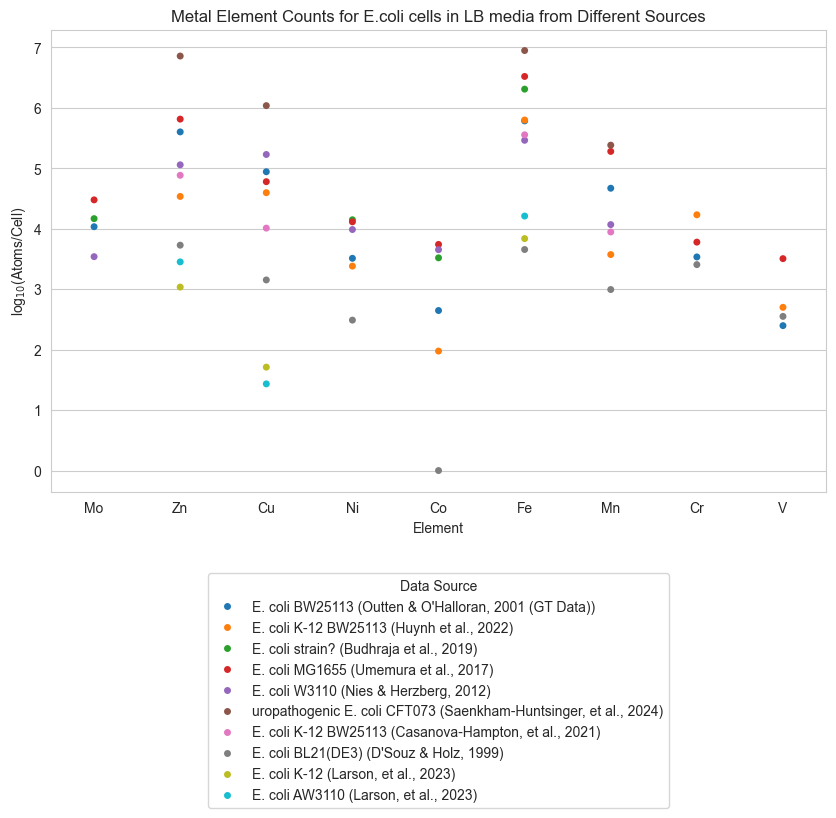

In [503]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.7))
plt.title("Metal Element Counts for E.coli cells in LB media from Different Sources")
plt.show()

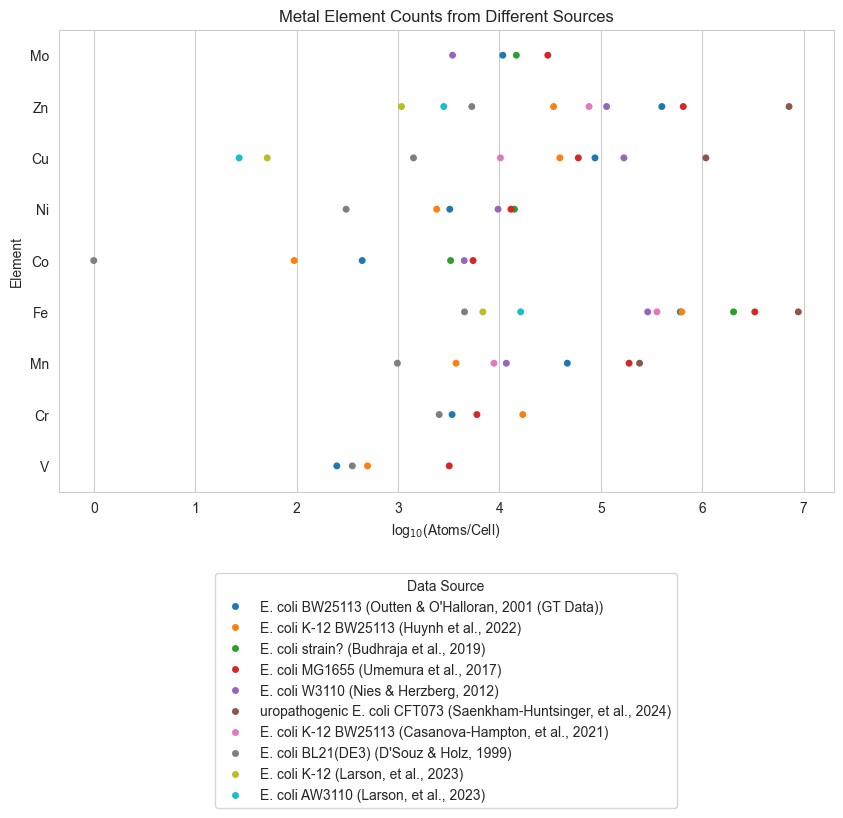

In [504]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.7))
plt.title("Metal Element Counts from Different Sources")
plt.show()

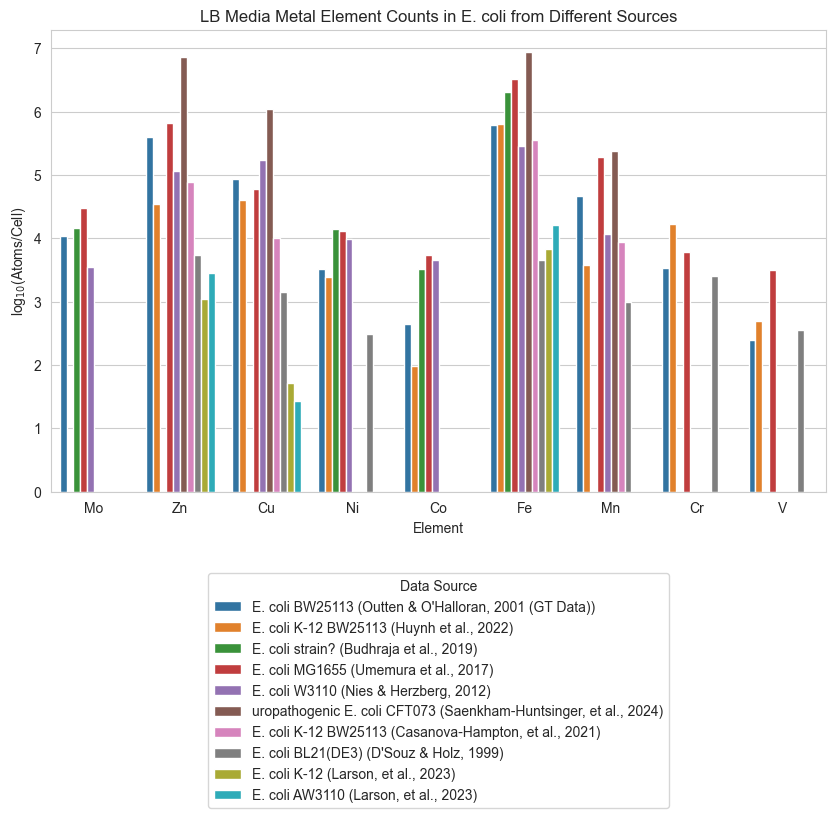

In [505]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_pd, x="Element", y="log$_{10}$(Atoms/Cell)", hue="Data Source")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.7))
plt.title("LB Media Metal Element Counts in E. coli from Different Sources")
plt.show()

# Plot with the median

Method 1: manually calc the median for each element (ie each row), and then sort by that column, and finally, drop that column out. Note that polars does not recognize row names, so might need to remove element names  before sorting. 

In [506]:
# todo: ask cyrus if he knows an easier way to do this in polars
# calculate the median for each element:
df = lb_exp_data.drop("Element") # order is Mo, Zn, Cu, Ni, Co, Fe, Mn, Cr, V
Mo_median = df.row(0)


Method 2: transpose the data frame and then sort by the median of each column.
Still have to manually get the mean of each column and then manually tell it to sort by a certain order

In [507]:
# todo ask cyrus if he knows an easier way to do this in polars
# Transpose the DF for sorting
lb_exp_dataT = lb_exp_data.drop("Element")
lb_exp_dataT = lb_exp_dataT.transpose(include_header=True, header_name="Source", column_names=lb_exp_data.get_column("Element"))
print(lb_exp_dataT)

# calculate the median for each column:
# could also probably use: lb_exp_dataT.select(pl.median("Mo"))
Mo_median = lb_exp_dataT.select("Mo").median()
Zn_median = lb_exp_dataT.select("Zn").median()
Cu_median = lb_exp_dataT.select("Cu").median()
Co_median = lb_exp_dataT.select("Co").median()
Ni_median = lb_exp_dataT.select("Ni").median()
Fe_median = lb_exp_dataT.select("Fe").median()
Mn_median = lb_exp_dataT.select("Mn").median()
Cr_median = lb_exp_dataT.select("Cr").median()
V_median = lb_exp_dataT.select("V").median()

medians = [Mo_median.item(), Zn_median.item(), Cu_median.item(), Ni_median.item(), Co_median.item(), Fe_median.item(), Mn_median.item(), Cr_median.item(), V_median.item()]

# next, have to manually add this back to the original data frame, sort it, then drop the medians column

# create df with medians 
medians_df = pl.DataFrame({
    "Element": ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"],
    "Median": medians
})
print(medians_df)

# join the medians df with the original data frame! 
lb_exp_data_with_medians = lb_exp_data.join(medians_df, on="Element", how="left", coalesce=True)
print(lb_exp_data_with_medians)

# sort by the median column
lb_exp_data_sorted_medians = lb_exp_data_with_medians.sort("Median", descending=True)
print(lb_exp_data_with_medians)

# drop the median column
lb_exp_data_sorted_medians = lb_exp_data_sorted_medians.drop("Median")
print(lb_exp_data_sorted_medians)

# reshape the data for graphs
df_long_medians = lb_exp_data_sorted_medians.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_medians_pd = df_long_medians.to_pandas()


shape: (10, 10)
┌─────────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Source          ┆ Mo       ┆ Zn       ┆ Cu       ┆ … ┆ Fe       ┆ Mn       ┆ Cr       ┆ V        │
│ ---             ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str             ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ E. coli BW25113 ┆ 4.033304 ┆ 5.601669 ┆ 4.942388 ┆ … ┆ 5.783291 ┆ 4.669722 ┆ 3.533308 ┆ 2.396953 │
│ (Outten & O'Ha… ┆          ┆          ┆          ┆   ┆          ┆          ┆          ┆          │
│ E. coli K-12    ┆ null     ┆ 4.534125 ┆ 4.596439 ┆ … ┆ 5.79822  ┆ 3.5727   ┆ 4.230616 ┆ 2.699801 │
│ BW25113 (Huynh  ┆          ┆          ┆          ┆   ┆          ┆          ┆          ┆          │
│ et…             ┆          ┆          ┆          ┆   ┆          ┆        

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/3664118116.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  ax = sns.stripplot(data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")


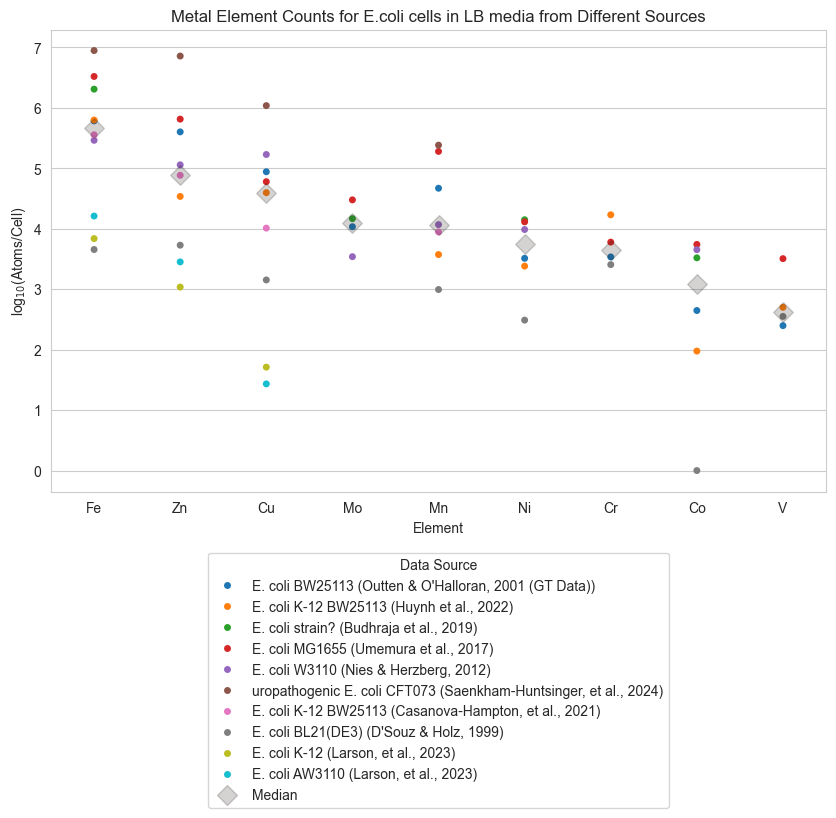

In [508]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False)

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.stripplot(data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.7))
plt.title("Metal Element Counts for E.coli cells in LB media from Different Sources")
plt.show()

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/4174158310.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  ax = sns.stripplot(data=long_medians_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")


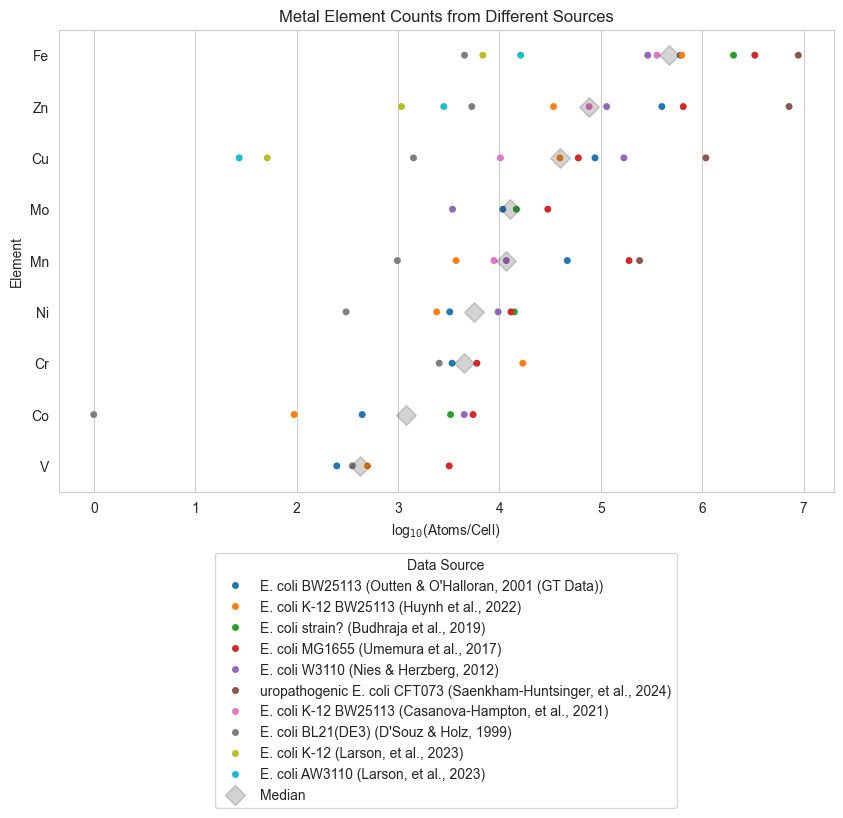

In [509]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False)

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.stripplot(data=long_medians_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.7))
plt.title("Metal Element Counts from Different Sources")
plt.show()

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/2722857925.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  ax = sns.stripplot(data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")


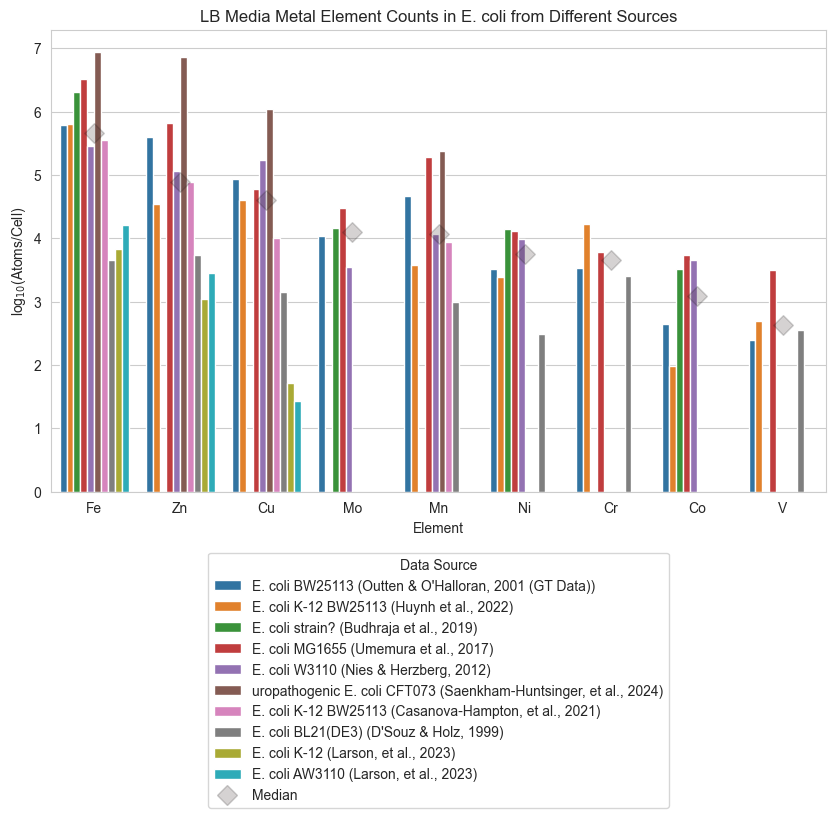

In [510]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_medians_pd, x="Element", y="log$_{10}$(Atoms/Cell)", hue="Data Source")

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
long_medians = medians_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_pd = long_medians.to_pandas()
ax = sns.stripplot(data=long_medians_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.7))
plt.title("LB Media Metal Element Counts in E. coli from Different Sources")
plt.show()

## template

Media type:  media

Bacterial species:

Units used in calculations:

QUESTIONS/ISSUES:

# Minimal Media Conditions Data

## Ground truth data from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/)

Media type: a custom A minimal media

Bacterial species: I believe E. coli BW25113

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES:
- need to confirm what type of minimal media conditions are used!

In [511]:
# load in the minimal media data from Outten & O'Halloran, 2001: https://pubmed.ncbi.nlm.nih.gov/11397910/
GT_mm_data = GT_data[:9]
GT_mm_df = pl.DataFrame(GT_mm_data[["Element","Atoms/cell"]])
GT_mm_df = GT_mm_df.with_columns(pl.col("Atoms/cell").log10().alias("E. coli BW25113 in custom A minimal media (Outten & O'Halloran, 2001 (GT Data))"))
GT_mm_df = pl.DataFrame(GT_mm_df[["Element", "E. coli BW25113 in custom A minimal media (Outten & O'Halloran, 2001 (GT Data))"]])

# replace the element names with the column names:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_mm_df = GT_mm_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_mm_df

Element,"E. coli BW25113 in custom A minimal media (Outten & O'Halloran, 2001 (GT Data))"
str,f64
"""Mo""",3.600246
"""Zn""",5.300613
"""Cu""",3.894907
"""Ni""",3.577501
"""Co""",2.716067
"""Fe""",5.25522
"""Mn""",3.520492
"""Cr""",3.192079
"""V""",2.96536


## Minimal media data from Huynh et al., 2022 fig 1c and 1d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 

Media type: a-minimal media

Bacterial species: E. coli K-12 BW25113

Units used in calculations: Atoms/CFU

QUESTIONS/ISSUES: 

In [512]:
# load in minimal media data from Huynh et al., 2022 fig 1c and d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
H_mm_2022 = pd.read_excel("notebooks/mia_notebooks/Huynh_2022_F1CD_data.xlsx")

# convert data frames to polars data frames and rename the columns to be more descriptive: 
H_mm_2022 = pl.DataFrame(H_mm_2022[["Element","log10 AM (atoms/CFU)"]])
H_mm_2022 = H_mm_2022.with_columns(pl.col("log10 AM (atoms/CFU)").alias("E. coli K-12 BW25113 in A-minimal media (Huynh et al., 2022)"))
H_mm_2022 = pl.DataFrame(H_mm_2022[["Element", "E. coli K-12 BW25113 in A-minimal media (Huynh et al., 2022)"]])
H_mm_2022

Element,"E. coli K-12 BW25113 in A-minimal media (Huynh et al., 2022)"
str,f64
"""Mn""",2.913947
"""Fe""",5.780415
"""Cu""",3.661721
"""Zn""",4.142433
"""V""",2.449304
"""Cr""",3.903579
"""Co""",1.586481
"""Ni""",2.922465


## Minimal media data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data):

Media type: minimal media

Bacterial species: need strain info still

Units used in calculations: metal ions per cell

QUESTIONS/ISSUES:
- media makeup is quite custom, how should I name it in the graph? 

In [513]:
# load in the minimal media data from Budhraja et al., 2019: https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data
B_mm_2019 = pd.read_excel("notebooks/mia_notebooks/Budhraja_2019_F1all_2019.xlsx")
B_mm_air_2019 = pl.DataFrame(B_mm_2019[["Element","log10 MM air (metal ions per cell)"]])
B_mm_air_2019 = B_mm_air_2019.with_columns(pl.col("log10 MM air (metal ions per cell)").alias("E. coli strain? in custom aerobic minimal media (Budhraja et al., 2019)"))

B_mm_xair_2019 = pl.DataFrame(B_mm_2019[["Element","log10 MM xair (metal ions per cell) "]])
B_mm_xair_2019 = B_mm_xair_2019.with_columns(pl.col("log10 MM xair (metal ions per cell) ").alias("E. coli strain? in custom anaerobic minimal media (Budhraja et al., 2019)"))
B_mm_xair_2019

Element,log10 MM xair (metal ions per cell),"E. coli strain? in custom anaerobic minimal media (Budhraja et al., 2019)"
str,f64,f64
"""Fe""",6.875181,6.875181
"""Co""",5.354136,5.354136
"""Ni""",4.111756,4.111756
"""Mo""",4.680697,4.680697


## M9 media from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11):

Media type: M9 media

Bacterial species: E. coli K-12 MG1655

Units used in calculations: atoms/cell

QUESTIONS/ISSUES:

In [514]:
# M9 data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
U_mm_2017 = pd.read_excel("notebooks/mia_notebooks/Umemura_2017_T112_data.xlsx")

# transform into a polars data frame and rename the columns:
U_mm_2017 = pl.DataFrame(U_mm_2017[["Symbol","E. coli\xa0MG1655 in M9"]])
U_mm_2017 = U_mm_2017.with_columns(pl.col("E. coli\xa0MG1655 in M9").log10().alias("E. coli K-12 MG1655 in M9 (Umemura et al., 2017)"))
U_mm_2017 = U_mm_2017.rename({"Symbol": "Element"})
U_mm_2017

Element,E. coli MG1655 in M9,"E. coli K-12 MG1655 in M9 (Umemura et al., 2017)"
str,f64,f64
"""Mg""",1.1e8,8.041393
"""P""",5.6e8,8.748188
"""S""",1.5e8,8.176091
"""K""",4.2e8,8.623249
"""Ca""",3.8e6,6.579784
…,…,…
"""Au""",null,null
"""Tl""",null,null
"""Pb""",120.0,2.079181


## MOPS data from Xu, et al., 2017, figure 1a: https://www.sciencedirect.com/science/article/pii/S002192582030538X?via%3Dihub#sec1

Media type: MOPS media

Bacterial species: E. coli MG1655

Units used in calculations: Intracellular metal content (per cell) in No Zn(II) supplement (assuming this means atoms/cell)

QUESTIONS/ISSUES: 
- comfirm that the units are equivalent to atoms/cell

In [515]:
# load in the data from Xu et al., 2017, figure 1a: https://www.sciencedirect.com/science/article/pii/S002192582030538X?via%3Dihub#sec1
Xu_F1A_2019 = pd.read_excel("notebooks/mia_notebooks/Xu_2019_F1A_data.xlsx")
X_mm_2019 = pl.DataFrame(Xu_F1A_2019[["Element","Intracellular metal content (per cell) in No Zn(II) supplement"]])
X_mm_2019 = X_mm_2019.with_columns(pl.col("Intracellular metal content (per cell) in No Zn(II) supplement").log10().alias("E. coli MG1655 in MOPS (Xu et al., 2019)"))
X_mm_2019

Element,Intracellular metal content (per cell) in No Zn(II) supplement,"E. coli MG1655 in MOPS (Xu et al., 2019)"
str,i64,f64
"""Zn""",140000,5.146128
"""Fe""",380000,5.579784
"""Mn""",32000,4.50515
"""Ni""",3000,3.477121
"""Cu""",20000,4.30103


## M9 Media data from Osman, et al., 2019: https://www.nature.com/articles/s41589-018-0211-4#Sec24

Media type: M9 minimal medium, supplemented with thiamine (10 μg ml−1) and L-histidine (20 μg ml−1)

Bacterial species: Salmonella enterica serovar Typhimurium strain SL1344 

Units used in calculations: atoms/cell

QUESTIONS/ISSUES:
- not sure how I should mention the other additivies in the media 

In [516]:
# load in the data from Osman et al., 2019: https://www.nature.com/articles/s41589-018-0211-4#Sec24
Osman_mm_2019 = pd.read_excel("notebooks/mia_notebooks/Osman_2019_ST3_data.xlsx")
Osman_mm_2019 = pl.DataFrame(Osman_mm_2019[["Element","Total Metal (atoms/cell), Control"]])
O_mm_2019 = Osman_mm_2019.with_columns(pl.col("Total Metal (atoms/cell), Control").log10().alias("Salmonella in M9 (Osman et al., 2019)"))
O_mm_2019

Element,"Total Metal (atoms/cell), Control","Salmonella in M9 (Osman et al., 2019)"
str,i64,f64
"""Mg""",26000000,7.414973
"""Mn""",160000,5.20412
"""Fe""",200000,5.30103
"""Co""",900,2.954243
"""Zn""",190000,5.278754
"""Ni""",4600,3.662758
"""Cu""",5100,3.70757


## MOPS Media data from LaVoie, et al., 2015: https://link.springer.com/article/10.1007/s00775-015-1303-1/figures/4

Media type: MOPS minimal medium supplemented with 20 mg/L uracil and 5 mg/L thiamine

Bacterial species: E. coli MG1655

Units used in calculations: atoms/cell

QUESTIONS/ISSUES:
- it would appear that there may be LB media used in the beginning of the incubation? Not exactly sure how that would affect the data.
- it also seems like the MOPS has some addititves to it, would this affect what I call it?

In [517]:
# load in the data from LaVoie et al., 2015: https://link.springer.com/article/10.1007/s00775-015-1303-1/figures/4
LaVoie_F4_2015 = pd.read_excel("notebooks/mia_notebooks/LaVoie_2015_F4_data.xlsx")
L_mm_2015 = pl.DataFrame(LaVoie_F4_2015[["Element","unexposed"]])
L_mm_2015 = L_mm_2015.rename({"unexposed": "E. coli K-12 MG1655 in MOPS (LaVoie et al., 2015)"})
L_mm_2015

Element,"E. coli K-12 MG1655 in MOPS (LaVoie et al., 2015)"
str,f64
"""Mg""",7.339623
"""Mn""",4.450135
"""Fe""",5.894879
"""Co""",3.975741
"""Ni""",3.609164
"""Cu""",4.277628
"""Zn""",4.838275


## Beauchene, 2014: https://asset.library.wisc.edu/1711.dl/LE7AB2DFQKDIP8O/R/file-1aa76.pdf

Media type: MOPS minimal glucose media with 10 µM FeSO4, Aerobic conditions and Anaerobic conditions

Bacterial species: E. coli K12 MG1655, but potentially also PK9427, PK10474, and PK10475? seems like MG1655 had PK9427 added into it?

Original Units: µg/mL cell lysate

QUESTIONS/ISSUES:
- unit conversion needs to be double checked 
- not sure about how to classify the media type? should I just throw it in my "hybrid" bin? it says MOPS but has some additives  
- need to figure out what the exact strain is in the table (if it has any of those others in it)
- is it wet or dry mass that I should be using for the conversion? I am pretty sure dry, but not totally sure

In [518]:
# load in the data from Beauchene, 2014: https://asset.library.wisc.edu/1711.dl/LE7AB2DFQKDIP8O/R/file-1aa76.pdf
Beauchene_T22_2014 = pd.read_excel("notebooks/mia_notebooks/Beauchene_2014_T2_2_data.xlsx")
B_mm_air_2014 = pl.DataFrame(Beauchene_T22_2014[["Element","Aerobic Growth (µg/mL cell lysate)"]])
B_mm_xair_2014 = pl.DataFrame(Beauchene_T22_2014[["Element","Anaerobic Growth (µg/mL cell lysate)"]])

# filter out the elements that are not in the ground truth data:
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]
B_mm_air_2014 = B_mm_air_2014.select(["Element", "Aerobic Growth (µg/mL cell lysate)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_xair_2014 = B_mm_xair_2014.select(["Element", "Anaerobic Growth (µg/mL cell lysate)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_air_2014

Element,Aerobic Growth (µg/mL cell lysate)
str,f64
"""Mn""",1.066
"""Co""",0.07
"""Ni""",0.012
"""Zn""",2.143
"""Fe""",6.306
"""Cu""",0.163


In [519]:
# convert from µg/mL cell lysate to g/mL:
B_mm_air_2014 = B_mm_air_2014.with_columns((pl.col("Aerobic Growth (µg/mL cell lysate)") * 10**(-6)).alias("Aerobic Growth (g/mL cell lysate)")) # 1*10^-6 g/mL = 1 µg/mL
B_mm_air_2014 = B_mm_air_2014.with_columns((pl.col("Aerobic Growth (g/mL cell lysate)") / (3.3*10**(-5)) ).alias("Aerobic Growth (g-element/g-cell-pellet)")) # 0.033 mg = 3.3*10^-5 g

B_mm_xair_2014 = B_mm_xair_2014.with_columns((pl.col("Anaerobic Growth (µg/mL cell lysate)") * 10**(-6)).alias("Anaerobic Growth (g/mL cell lysate)")) # 1*10^-6 g/mL = 1 µg/mL
B_mm_xair_2014 = B_mm_xair_2014.with_columns((pl.col("Anaerobic Growth (g/mL cell lysate)") / (3.3*10**(-5))).alias("Anaerobic Growth (g-element/g-cell-pellet)")) # 0.033 mg = 3.3*10^-5 g

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_Mn = 54.938  # g/mol
mm_Ni = 58.693 # g/mol
mm_Co = 58.933 # g/mol
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol
cell_mass = 1e-12  # g (average mass of a dry E. coli cell according to https://ecmdb.ca/e_coli_stats) # TODO: confirm it is the dry mass I should be using (I think so becuase they mainly reference dry cells in the paper) 

# convert from g-atom/g-cell-pellet to atoms/cell (assume that cell-pellet = cell):
Fe_value = B_mm_air_2014.filter(pl.col("Element") == "Fe").select("Aerobic Growth (g-element/g-cell-pellet)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro * cell_mass
Mn_value = B_mm_air_2014.filter(pl.col("Element") == "Mn").select("Aerobic Growth (g-element/g-cell-pellet)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro * cell_mass
Zn_value = B_mm_air_2014.filter(pl.col("Element") == "Zn").select("Aerobic Growth (g-element/g-cell-pellet)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro * cell_mass
Cu_value = B_mm_air_2014.filter(pl.col("Element") == "Cu").select("Aerobic Growth (g-element/g-cell-pellet)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro * cell_mass
Co_value = B_mm_air_2014.filter(pl.col("Element") == "Co").select("Aerobic Growth (g-element/g-cell-pellet)").item(); Co_value = (Co_value / mm_Co) * Avogadro * cell_mass
Ni_value = B_mm_air_2014.filter(pl.col("Element") == "Ni").select("Aerobic Growth (g-element/g-cell-pellet)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro * cell_mass
B_mm_air_2014_values = [Mn_value, Co_value, Ni_value, Zn_value, Fe_value, Cu_value]

# merge values 
B_mm_air_2014 = B_mm_air_2014.select(["Element", "Aerobic Growth (g-element/g-cell-pellet)"])
B_mm_air_2014 = B_mm_air_2014.with_columns([pl.Series("Aerobic Growth (atoms/cell)", B_mm_air_2014_values)])
B_mm_air_2014 = B_mm_air_2014.with_columns(pl.col("Aerobic Growth (atoms/cell)").log10().alias("E. coli K-12 MG1655 in Aerobic MOPS (Beauchene, 2014)"))
B_mm_air_2014

# repeat with anaerobic conditions: 
Fe_value = B_mm_xair_2014.filter(pl.col("Element") == "Fe").select("Anaerobic Growth (g-element/g-cell-pellet)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro * cell_mass
Mn_value = B_mm_xair_2014.filter(pl.col("Element") == "Mn").select("Anaerobic Growth (g-element/g-cell-pellet)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro * cell_mass
Zn_value = B_mm_xair_2014.filter(pl.col("Element") == "Zn").select("Anaerobic Growth (g-element/g-cell-pellet)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro * cell_mass
Cu_value = B_mm_xair_2014.filter(pl.col("Element") == "Cu").select("Anaerobic Growth (g-element/g-cell-pellet)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro * cell_mass
Co_value = B_mm_xair_2014.filter(pl.col("Element") == "Co").select("Anaerobic Growth (g-element/g-cell-pellet)").item(); Co_value = (Co_value / mm_Co) * Avogadro * cell_mass
Ni_value = B_mm_xair_2014.filter(pl.col("Element") == "Ni").select("Anaerobic Growth (g-element/g-cell-pellet)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro * cell_mass
B_mm_xair_2014_values = [Mn_value, Co_value, Ni_value, Zn_value, Fe_value, Cu_value]

B_mm_xair_2014 = B_mm_xair_2014.select(["Element", "Anaerobic Growth (g-element/g-cell-pellet)"])
B_mm_xair_2014 = B_mm_xair_2014.with_columns([pl.Series("Anaerobic Growth (atoms/cell)", B_mm_xair_2014_values)])
B_mm_xair_2014 = B_mm_xair_2014.with_columns(pl.col("Anaerobic Growth (atoms/cell)").log10().alias("E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, 2014)"))
B_mm_xair_2014

Element,Anaerobic Growth (g-element/g-cell-pellet),Anaerobic Growth (atoms/cell),"E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, 2014)"
str,f64,f64,f64
"""Mn""",0.000879,9.6328e6,6.983752
"""Co""",0.000394,4.0254e6,6.604812
"""Ni""",0.000212,2.1764e6,6.337739
"""Zn""",0.040636,3.7429e8,8.573211
"""Fe""",0.227515,2.4534e9,9.389767
"""Cu""",0.008182,7.7536e7,7.889502


## Beauchene, et al., 2015: https://journals.asm.org/doi/full/10.1128/mbio.01947-15#ngtab1-1

Media type: MOPS minimal glucose media with 10 µM FeSO4, Aerobic conditions and Anaerobic conditions

Bacterial species: E. coli K12 MG1655, but potentially also PK9427, PK10474, and PK10475? seems like MG1655 had PK9427 added into it?

Original Units: ng/mg cell pellet

QUESTIONS/ISSUES:
- unit conversion needs to be doublechecked 
- is this the same data as the 2014 paper? 
- not sure about how to classify the media type? should I just throw it in my "hybrid" bin? it says MOPS but has some iron  
- need to figure out what the exact strain is in the table (if it has any of those others in it)
- is it wet or dry mass that I should be using for the conversion? I am pretty sure dry, but not totally sure

In [520]:
# load in the data from Beauchene, et al., 2015: https://journals.asm.org/doi/full/10.1128/mbio.01947-15#ngtab1-1
Beauchene_T1_2015 = pd.read_excel("notebooks/mia_notebooks/Beauchene_2015_T1_data.xlsx")
B_mm_air_2015 = pl.DataFrame(Beauchene_T1_2015[["Element","Aerobic growth (ng/mg cell pellet)"]])
B_mm_xair_2015 = pl.DataFrame(Beauchene_T1_2015[["Element","Anaerobic growth (ng/mg cell pellet)"]])

# filter out the elements that are not in the ground truth data:
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]
B_mm_air_2015 = B_mm_air_2015.select(["Element", "Aerobic growth (ng/mg cell pellet)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_xair_2015 = B_mm_xair_2015.select(["Element", "Anaerobic growth (ng/mg cell pellet)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_air_2015

Element,Aerobic growth (ng/mg cell pellet)
str,f64
"""Mn""",3.23
"""Co""",0.213
"""Ni""",0.0369
"""Zn""",6.49
"""Fe""",19.1
"""Cu""",0.494


In [521]:
# convert from ng/mg cell pellet to g-element/g-cell:
B_mm_air_2015 = B_mm_air_2015.with_columns((pl.col("Aerobic growth (ng/mg cell pellet)") * 10**(-6)).alias("Aerobic Growth (g-element/g-cell-pellet)")) # 1*10^-6 g/g = 1 ng/mg
B_mm_air_2015 = B_mm_air_2015.with_columns((pl.col("Aerobic Growth (g-element/g-cell-pellet)") / .3 ).alias("Aerobic Growth (g-element/g-cell)")) # .3 g cell/g cell pellet? # todo ask cyrus if he agrees with this interpretation of the figure's instructions

B_mm_xair_2015 = B_mm_xair_2015.with_columns((pl.col("Anaerobic growth (ng/mg cell pellet)") * 10**(-6)).alias("Anaerobic Growth (g-element/g-cell-pellet)")) # 1*10^-6 g/g = 1 ng/mg
B_mm_xair_2015 = B_mm_xair_2015.with_columns((pl.col("Anaerobic Growth (g-element/g-cell-pellet)") / .3 ).alias("Anaerobic Growth (g-element/g-cell)")) 

# conversion numbers (all molar masses are from https://ptable.com/?lang=en#Properties):
mm_Mn = 54.938  # g/mol
mm_Ni = 58.693 # g/mol
mm_Co = 58.933 # g/mol
mm_Cu = 63.546  # g/mol
mm_Fe = 55.845  # g/mol
mm_Zn = 65.380  # g/mol
Avogadro = 6.022 * 10**23  # atoms/mol
cell_mass = 1e-12  # g (average mass of a dry E. coli cell according to https://ecmdb.ca/e_coli_stats) # todo ask cyrus if I should use wet or dry mass? 

# convert from g-element/g-cell-pellet to atoms/cell (assume that cell-pellet = cell):
Fe_value = B_mm_air_2015.filter(pl.col("Element") == "Fe").select("Aerobic Growth (g-element/g-cell)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro * cell_mass 
Mn_value = B_mm_air_2015.filter(pl.col("Element") == "Mn").select("Aerobic Growth (g-element/g-cell)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro * cell_mass
Zn_value = B_mm_air_2015.filter(pl.col("Element") == "Zn").select("Aerobic Growth (g-element/g-cell)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro * cell_mass
Cu_value = B_mm_air_2015.filter(pl.col("Element") == "Cu").select("Aerobic Growth (g-element/g-cell)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro * cell_mass
Co_value = B_mm_air_2015.filter(pl.col("Element") == "Co").select("Aerobic Growth (g-element/g-cell)").item(); Co_value = (Co_value / mm_Co) * Avogadro * cell_mass
Ni_value = B_mm_air_2015.filter(pl.col("Element") == "Ni").select("Aerobic Growth (g-element/g-cell)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro * cell_mass
B_mm_air_2015_values = [Mn_value, Co_value, Ni_value, Zn_value, Fe_value, Cu_value]

# merge values 
B_mm_air_2015 = B_mm_air_2015.select(["Element", "Aerobic Growth (g-element/g-cell)"])
B_mm_air_2015 = B_mm_air_2015.with_columns([pl.Series("Aerobic Growth (atoms/cell)", B_mm_air_2015_values)])
B_mm_air_2015 = B_mm_air_2015.with_columns(pl.col("Aerobic Growth (atoms/cell)").log10().alias("E. coli K-12 MG1655 in Aerobic MOPS (Beauchene, et al., 2015)"))
B_mm_air_2015

# repeat with anaerobic conditions: 
Fe_value = B_mm_xair_2015.filter(pl.col("Element") == "Fe").select("Anaerobic Growth (g-element/g-cell)").item(); Fe_value = (Fe_value / mm_Fe) * Avogadro * cell_mass
Mn_value = B_mm_xair_2015.filter(pl.col("Element") == "Mn").select("Anaerobic Growth (g-element/g-cell)").item(); Mn_value = (Mn_value / mm_Mn) * Avogadro * cell_mass
Zn_value = B_mm_xair_2015.filter(pl.col("Element") == "Zn").select("Anaerobic Growth (g-element/g-cell)").item(); Zn_value = (Zn_value / mm_Zn) * Avogadro * cell_mass
Cu_value = B_mm_xair_2015.filter(pl.col("Element") == "Cu").select("Anaerobic Growth (g-element/g-cell)").item(); Cu_value = (Cu_value / mm_Cu) * Avogadro * cell_mass
Co_value = B_mm_xair_2015.filter(pl.col("Element") == "Co").select("Anaerobic Growth (g-element/g-cell)").item(); Co_value = (Co_value / mm_Co) * Avogadro * cell_mass
Ni_value = B_mm_xair_2015.filter(pl.col("Element") == "Ni").select("Anaerobic Growth (g-element/g-cell)").item(); Ni_value = (Ni_value / mm_Ni) * Avogadro * cell_mass
B_mm_xair_2015_values = [Mn_value, Co_value, Ni_value, Zn_value, Fe_value, Cu_value]

B_mm_xair_2015 = B_mm_xair_2015.select(["Element", "Anaerobic Growth (g-element/g-cell)"])
B_mm_xair_2015 = B_mm_xair_2015.with_columns([pl.Series("Anaerobic Growth (atoms/cell)", B_mm_xair_2015_values)])
B_mm_xair_2015 = B_mm_xair_2015.with_columns(pl.col("Anaerobic Growth (atoms/cell)").log10().alias("E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, et al., 2015)"))
B_mm_xair_2015

Element,Anaerobic Growth (g-element/g-cell),Anaerobic Growth (atoms/cell),"E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, et al., 2015)"
str,f64,f64,f64
"""Mn""",2.9400e-7,3222.66555,3.508215
"""Co""",1.2967e-7,1324.983739,3.122211
"""Ni""",7.4333e-8,762.672437,2.882338
"""Zn""",0.000014,124652.391149,5.095701
"""Fe""",0.000076,819539.797654,5.91357
"""Cu""",0.000003,25839.528321,4.412285


## Minimal Media Plots

In [522]:
# Combine all minimal media data:
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source
H_mm_2022 = H_mm_2022.select(["Element", "E. coli K-12 BW25113 in A-minimal media (Huynh et al., 2022)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_air_2019 = B_mm_air_2019.select(["Element", "E. coli strain? in custom aerobic minimal media (Budhraja et al., 2019)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_xair_2019 = B_mm_xair_2019.select(["Element", "E. coli strain? in custom anaerobic minimal media (Budhraja et al., 2019)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_air_2014 = B_mm_air_2014.select(["Element", "E. coli K-12 MG1655 in Aerobic MOPS (Beauchene, 2014)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_xair_2014 = B_mm_xair_2014.select(["Element", "E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, 2014)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_air_2015 = B_mm_air_2015.select(["Element", "E. coli K-12 MG1655 in Aerobic MOPS (Beauchene, et al., 2015)"]).filter(pl.col("Element").is_in(overlap_element_names))
B_mm_xair_2015 = B_mm_xair_2015.select(["Element", "E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, et al., 2015)"]).filter(pl.col("Element").is_in(overlap_element_names))
U_mm_2017 = U_mm_2017.select(["Element", "E. coli K-12 MG1655 in M9 (Umemura et al., 2017)"]).filter(pl.col("Element").is_in(overlap_element_names))
X_mm_2019 = X_mm_2019.select(["Element", "E. coli MG1655 in MOPS (Xu et al., 2019)"]).filter(pl.col("Element").is_in(overlap_element_names))
O_mm_2019 = O_mm_2019.select(["Element", "Salmonella in M9 (Osman et al., 2019)"]).filter(pl.col("Element").is_in(overlap_element_names))
L_mm_2015 = L_mm_2015.select(["Element", "E. coli K-12 MG1655 in MOPS (LaVoie et al., 2015)"]).filter(pl.col("Element").is_in(overlap_element_names))

# Combine all minimal media data:
mm_exp_data = GT_mm_df.join(H_mm_2022, on="Element", how="left")
mm_exp_data = mm_exp_data.join(U_mm_2017, on="Element", how="left")
mm_exp_data = mm_exp_data.join(X_mm_2019, on="Element", how="left")
mm_exp_data = mm_exp_data.join(O_mm_2019, on="Element", how="left")
mm_exp_data = mm_exp_data.join(B_mm_air_2014, on="Element", how="left")
mm_exp_data = mm_exp_data.join(B_mm_xair_2014, on="Element", how="left")
mm_exp_data = mm_exp_data.join(B_mm_air_2015, on="Element", how="left")
mm_exp_data = mm_exp_data.join(B_mm_xair_2015, on="Element", how="left")
mm_exp_data = mm_exp_data.join(B_mm_air_2019, on="Element", how="left")
mm_exp_data = mm_exp_data.join(B_mm_xair_2019, on="Element", how="left")
mm_exp_data = mm_exp_data.join(L_mm_2015, on="Element", how="left")

# Edit dataframe format for plotting
df_mm_long = mm_exp_data.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_mm_long_pd = df_mm_long.to_pandas()

mm_exp_data

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/985909286.py:18: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  mm_exp_data = GT_mm_df.join(H_mm_2022, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/985909286.py:19: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  mm_exp_data = mm_exp_data.join(U_mm_2017, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/985909286.py:20: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  mm_exp_data = mm_exp_data.join(X_mm_201

Element,"E. coli BW25113 in custom A minimal media (Outten & O'Halloran, 2001 (GT Data))","E. coli K-12 BW25113 in A-minimal media (Huynh et al., 2022)","E. coli K-12 MG1655 in M9 (Umemura et al., 2017)","E. coli MG1655 in MOPS (Xu et al., 2019)","Salmonella in M9 (Osman et al., 2019)","E. coli K-12 MG1655 in Aerobic MOPS (Beauchene, 2014)","E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, 2014)","E. coli K-12 MG1655 in Aerobic MOPS (Beauchene, et al., 2015)","E. coli K-12 MG1655 in Anaerobic MOPS (Beauchene, et al., 2015)","E. coli strain? in custom aerobic minimal media (Budhraja et al., 2019)","E. coli strain? in custom anaerobic minimal media (Budhraja et al., 2019)","E. coli K-12 MG1655 in MOPS (LaVoie et al., 2015)"
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Mo""",3.600246,null,4.113943,null,null,null,null,null,null,4.297533,4.680697,null
"""Zn""",5.300613,4.142433,5.69897,5.146128,5.278754,8.776804,8.573211,5.299419,5.095701,null,null,4.838275
"""Cu""",3.894907,3.661721,4.845098,4.30103,3.70757,7.670326,7.889502,4.193258,4.412285,null,null,4.277628
"""Ni""",3.577501,2.922465,4.20412,3.477121,3.662758,6.571822,6.337739,3.10106,2.882338,4.239478,4.111756,3.609164
"""Co""",2.716067,1.586481,3.342423,null,2.954243,7.335966,6.604812,3.860641,3.122211,5.203193,5.354136,3.975741
"""Fe""",5.25522,5.780415,6.079181,5.579784,5.30103,9.313996,9.389767,5.836669,5.91357,6.979681,6.875181,5.894879
"""Mn""",3.520492,2.913947,4.643453,4.50515,5.20412,8.549111,6.983752,5.071949,3.508215,null,null,4.450135
"""Cr""",3.192079,3.903579,3.662758,null,null,null,null,null,null,null,null,null
"""V""",2.96536,2.449304,null,null,null,null,null,null,null,null,null,null


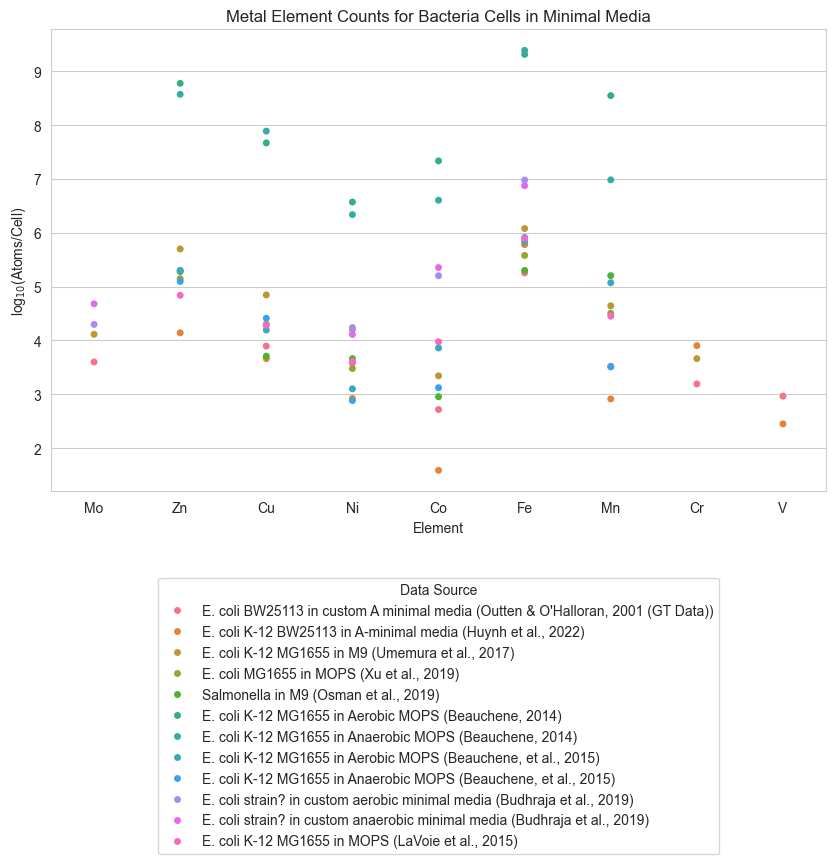

In [523]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_mm_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.8))
plt.title("Metal Element Counts for Bacteria Cells in Minimal Media")
plt.show()

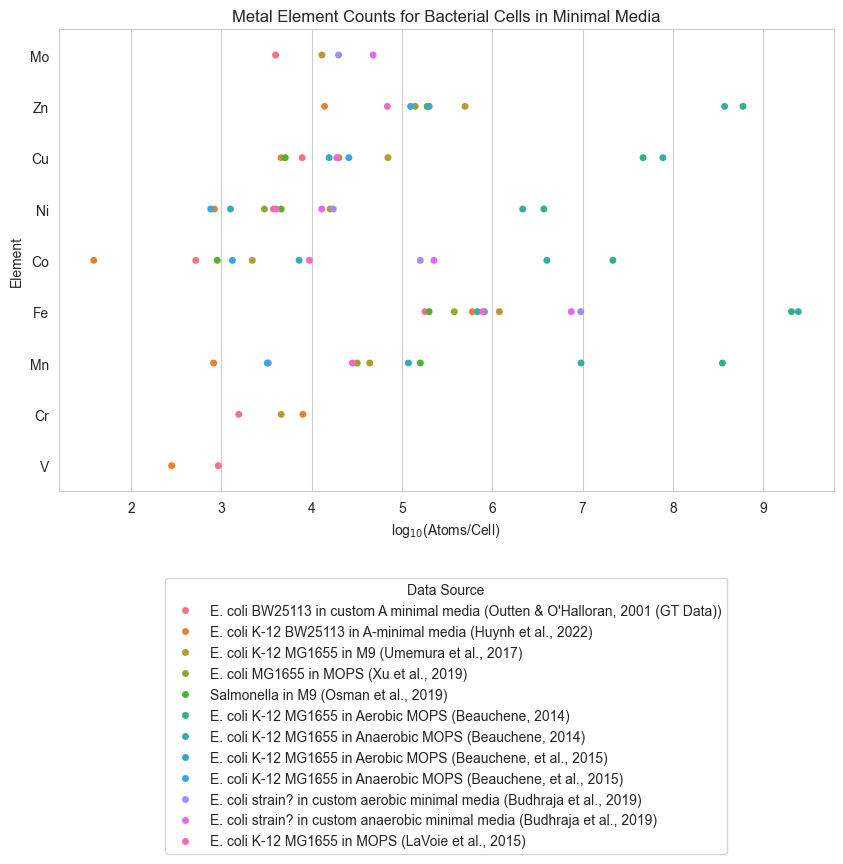

In [524]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_mm_long_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.8))
plt.title("Metal Element Counts for Bacterial Cells in Minimal Media")
plt.show()

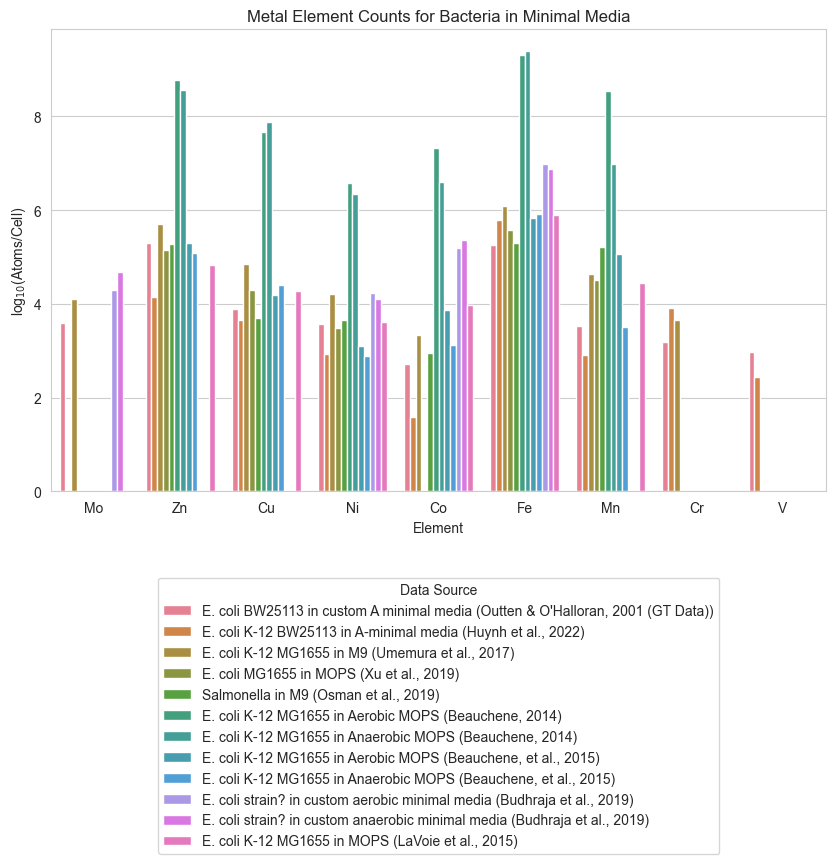

In [525]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_mm_long_pd, x="Element", y="log$_{10}$(Atoms/Cell)", hue="Data Source")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.8))
plt.title("Metal Element Counts for Bacteria in Minimal Media")
plt.show()

# plot with the median 

In [531]:
# todo ask cyrus if he knows an easier way to do this in polars
# Transpose the DF for sorting
mm_exp_dataT = mm_exp_data.drop("Element")
mm_exp_dataT = mm_exp_dataT.transpose(include_header=True, header_name="Source", column_names=mm_exp_data.get_column("Element"))
print(mm_exp_dataT)

# calculate the median for each column:
# could also probably use: lb_exp_dataT.select(pl.median("Mo"))
Mo_median = mm_exp_dataT.select("Mo").median()
Zn_median = mm_exp_dataT.select("Zn").median()
Cu_median = mm_exp_dataT.select("Cu").median()
Co_median = mm_exp_dataT.select("Co").median()
Ni_median = mm_exp_dataT.select("Ni").median()
Fe_median = mm_exp_dataT.select("Fe").median()
Mn_median = mm_exp_dataT.select("Mn").median()
Cr_median = mm_exp_dataT.select("Cr").median()
V_median = mm_exp_dataT.select("V").median()

medians_mm = [Mo_median.item(), Zn_median.item(), Cu_median.item(), Ni_median.item(), Co_median.item(), Fe_median.item(), Mn_median.item(), Cr_median.item(), V_median.item()]

# next, have to manually add this back to the original data frame, sort it, then drop the medians column

# create df with medians 
medians_mm_df = pl.DataFrame({
    "Element": ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"],
    "Median": medians_mm
})
long_medians_mm = medians_mm_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
long_medians_mm_pd = long_medians_mm.to_pandas()
print(medians_mm_df)

# join the medians df with the original data frame! 
mm_exp_data_with_medians = mm_exp_data.join(medians_mm_df, on="Element", how="left", coalesce=True)
print(mm_exp_data_with_medians)

# sort by the median column
mm_exp_data_sorted_medians = mm_exp_data_with_medians.sort("Median", descending=True)
print(mm_exp_data_sorted_medians)

# drop the median column
mm_exp_data_sorted_medians = mm_exp_data_sorted_medians.drop("Median")
print(mm_exp_data_sorted_medians)

# reshape the data for graphs
df_long_medians_mm = mm_exp_data_sorted_medians.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
df_long_medians_mm_pd = df_long_medians_mm.to_pandas()

shape: (12, 10)
┌─────────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Source          ┆ Mo       ┆ Zn       ┆ Cu       ┆ … ┆ Fe       ┆ Mn       ┆ Cr       ┆ V        │
│ ---             ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str             ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ E. coli BW25113 ┆ 3.600246 ┆ 5.300613 ┆ 3.894907 ┆ … ┆ 5.25522  ┆ 3.520492 ┆ 3.192079 ┆ 2.96536  │
│ in custom A mi… ┆          ┆          ┆          ┆   ┆          ┆          ┆          ┆          │
│ E. coli K-12    ┆ null     ┆ 4.142433 ┆ 3.661721 ┆ … ┆ 5.780415 ┆ 2.913947 ┆ 3.903579 ┆ 2.449304 │
│ BW25113 in      ┆          ┆          ┆          ┆   ┆          ┆          ┆          ┆          │
│ A-mini…         ┆          ┆          ┆          ┆   ┆          ┆        

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/832627614.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  ax = sns.stripplot(data=long_medians_mm_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")


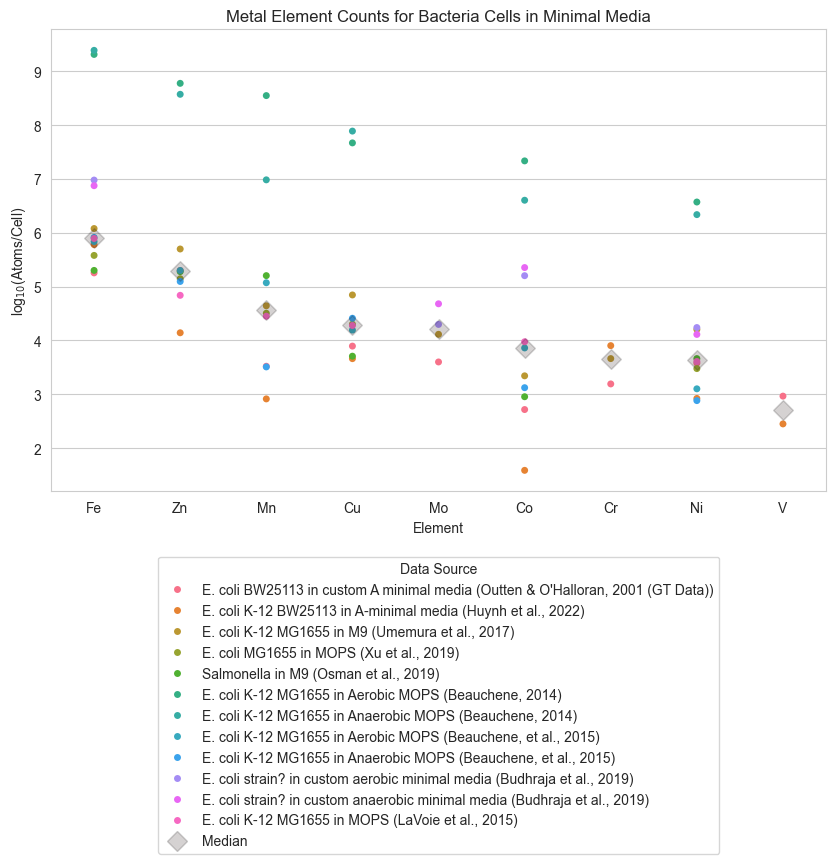

In [532]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_mm_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False)

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
ax = sns.stripplot(data=long_medians_mm_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.8))
plt.title("Metal Element Counts for Bacteria Cells in Minimal Media")
plt.show()

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/1022826202.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  ax = sns.stripplot(data=long_medians_mm_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")


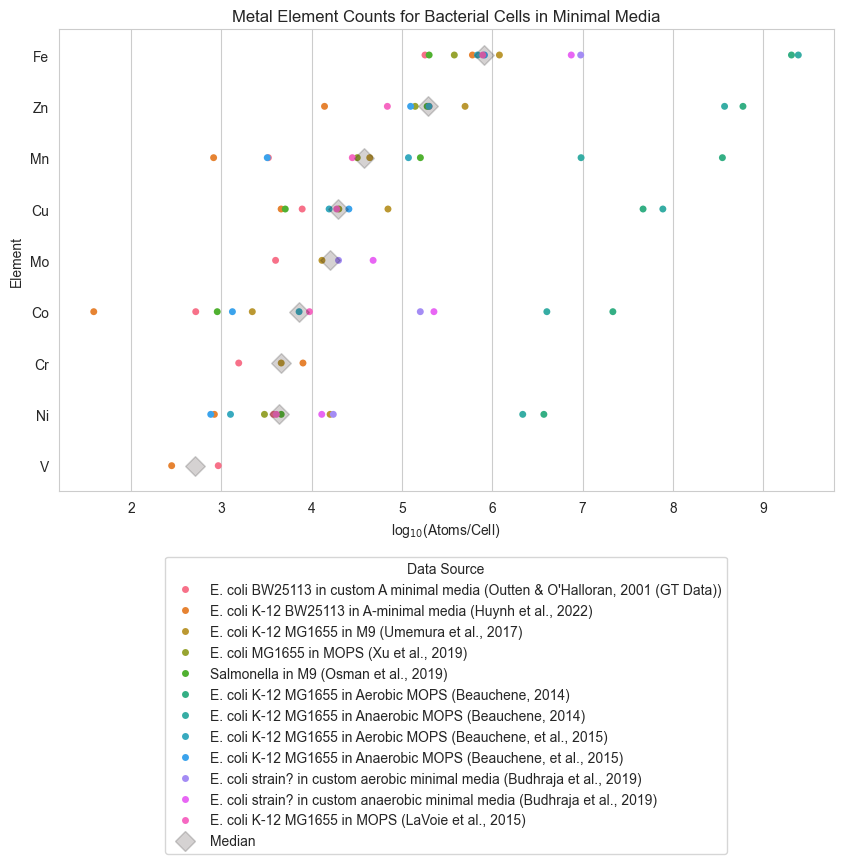

In [534]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_medians_mm_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False)

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
ax = sns.stripplot(data=long_medians_mm_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.8))
plt.title("Metal Element Counts for Bacterial Cells in Minimal Media")
plt.show()

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_70852/3393899504.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  ax = sns.stripplot(data=long_medians_mm_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")


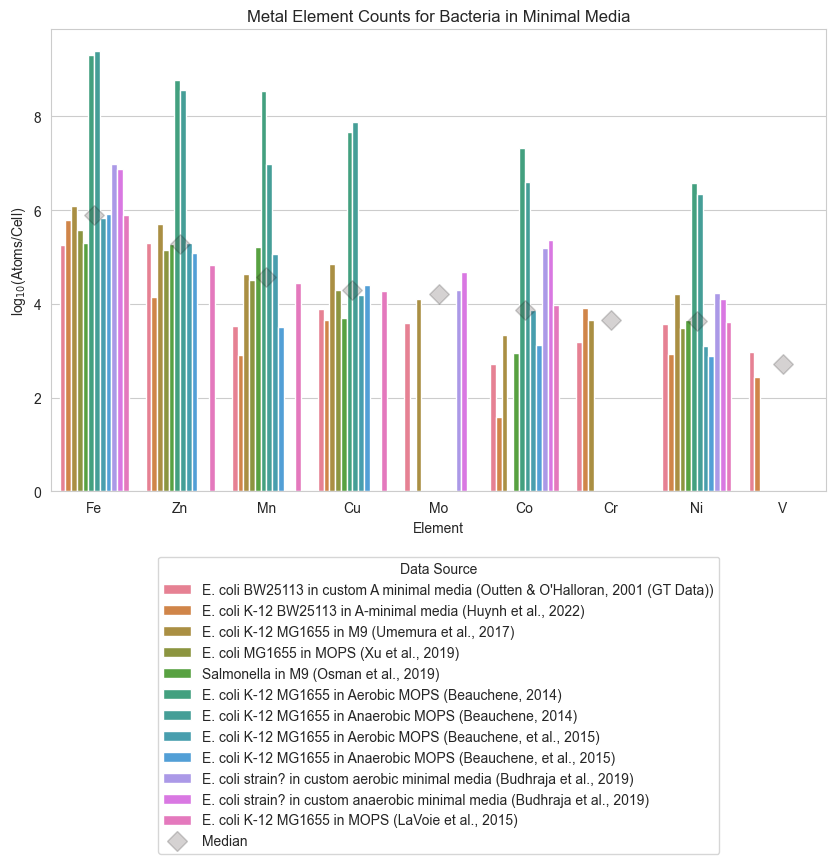

In [536]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_medians_mm_pd, x="Element", y="log$_{10}$(Atoms/Cell)", hue="Data Source")

# add a small marker at the median value of each element: 
# todo: ask cyrus if he knows how to not make the diamond go off center
ax = sns.stripplot(data=long_medians_mm_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False, s=10, marker="D", linewidth=1, alpha=.2, color="red")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.8))
plt.title("Metal Element Counts for Bacteria in Minimal Media")
plt.show()

## template

Media type:  media

Bacterial species:

Units used in calculations:

QUESTIONS/ISSUES:

# Hybrid media conditions?